# Tools

In [ ]:
import os
import numpy as np
import shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
 from google.colab import files
 _ = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
 97% 781M/806M [00:09<00:00, 99.2MB/s]
100% 806M/806M [00:10<00:00, 83.7MB/s]


In [ ]:
!unzip -o -qq menwomen-classification.zip

In [ ]:
mum_men_train = len(os.listdir('traindata/traindata/men'))
mum_women_train = len(os.listdir('traindata/traindata/women'))
mum_men_test = len(os.listdir('testdata/testdata/men'))
mum_women_test = len(os.listdir('testdata/testdata/women'))

print("mum men train: {0} & mum women train: {1}".format(mum_men_train, mum_women_train))
print("mum men test: {0} & mum women test: {1}".format(mum_men_test, mum_women_test))

mum men train: 1000 & mum women train: 1912
mum men test: 418 & mum women test: 915


In [ ]:
new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
  for category in ("men", "women"):
    dir = new_base_dir / subset_name / category
    if not os.path.exists(dir):
      os.makedirs(dir)
    files = os.listdir(os.path.join(base_dir, category))
    fnames = [files[i] for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=os.path.join(base_dir, category, fname),
      dst = os.path.join(dir, fname))

# Train-test split

In [ ]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

# Load Dataset

In [ ]:
print("Train Loader:")
train_dataset = image_dataset_from_directory(
    "men_vs_women_small/train",
    image_size= (180,180),
    batch_size= 32,
    label_mode= "binary"
)

print("Validation Loader:")
validation_dataset = image_dataset_from_directory(
    "men_vs_women_small/validation",
    image_size= (180,180),
    batch_size= 32,
    label_mode= "binary"
)

print("Test Loader:")
test_dataset = image_dataset_from_directory(
    "men_vs_women_small/test",
    image_size= (180,180),
    batch_size= 32,
    label_mode= "binary"
)

Train Loader:
Found 1598 files belonging to 2 classes.
Validation Loader:
Found 400 files belonging to 2 classes.
Test Loader:
Found 800 files belonging to 2 classes.


# Show examples

data batch shape: (32, 180, 180, 3)
label batch shape: (32, 180, 180, 3)


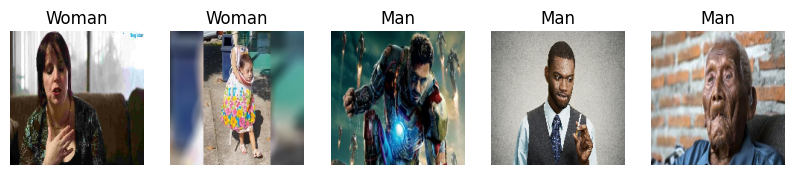

In [ ]:
for data_batch, label_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("label batch shape:", data_batch.shape)

  fig, axes = plt.subplots(1,5, figsize=(10,3))
  for i, ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype("uint8"))
    ax.set_axis_off()
    ax.set_title("Man" if label_batch[i].numpy()==0 else "Woman")
  break

plt.show()

# Model Desighn + VGG16

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (180, 180, 3)
)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
data_augmentention = keras.Sequential([
    layers.RandomFlip("horizental"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [ ]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentention(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("convent_from_scratch.keras", save_best_only=True, monitor="val_loss")]

In [ ]:
hist = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks, verbose=0)

# Results

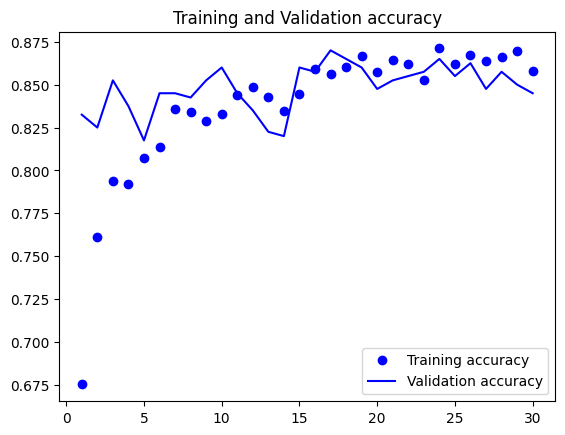

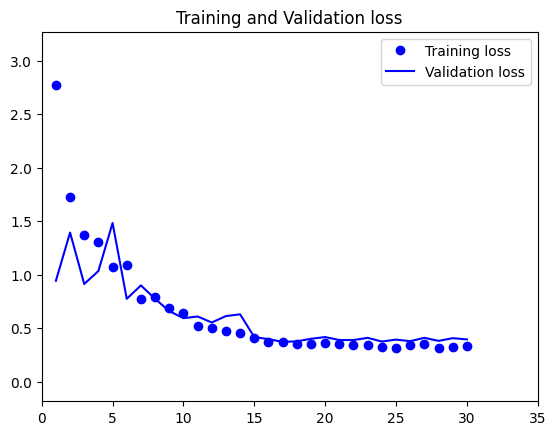

In [ ]:
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label= "Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and Validation loss")
plt.xlim(0, max(epochs) + 5)
plt.ylim(min(loss + val_loss) - 0.5, max(loss + val_loss) + 0.5)
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.8780 - loss: 0.3171


# Model tuning and training

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate= 1e-5), metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("fine_tuningl.keras", save_best_only=True, monitor="val_loss")]

In [ ]:
hist = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks, verbose=0)

# Results

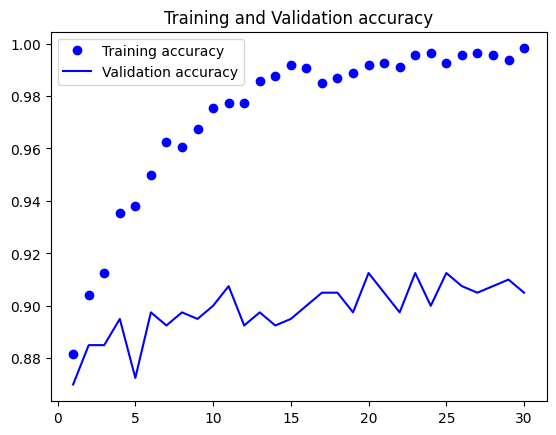

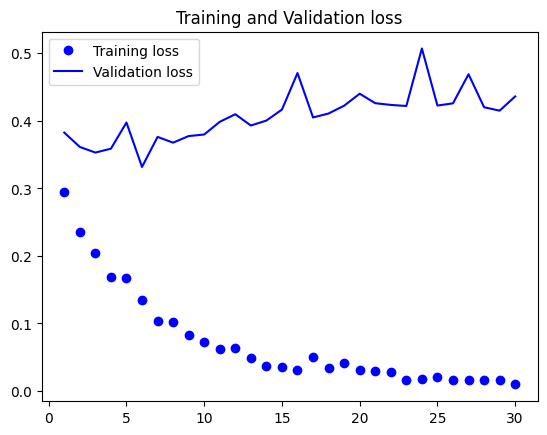

In [ ]:
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label= "Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label= "Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9333 - loss: 0.2396


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

ValueError: mount failed

In [ ]:
!cp 'fine_tuningl.keras' '/content/drive/MyDrive/'